Current Time = 08:11:36
img shape=  (512, 512)
img shape=  (2000, 2000)
rho shape = (4000000,)
K = 2, T = 20
img shape=  (4000000,)

Plotting .... 


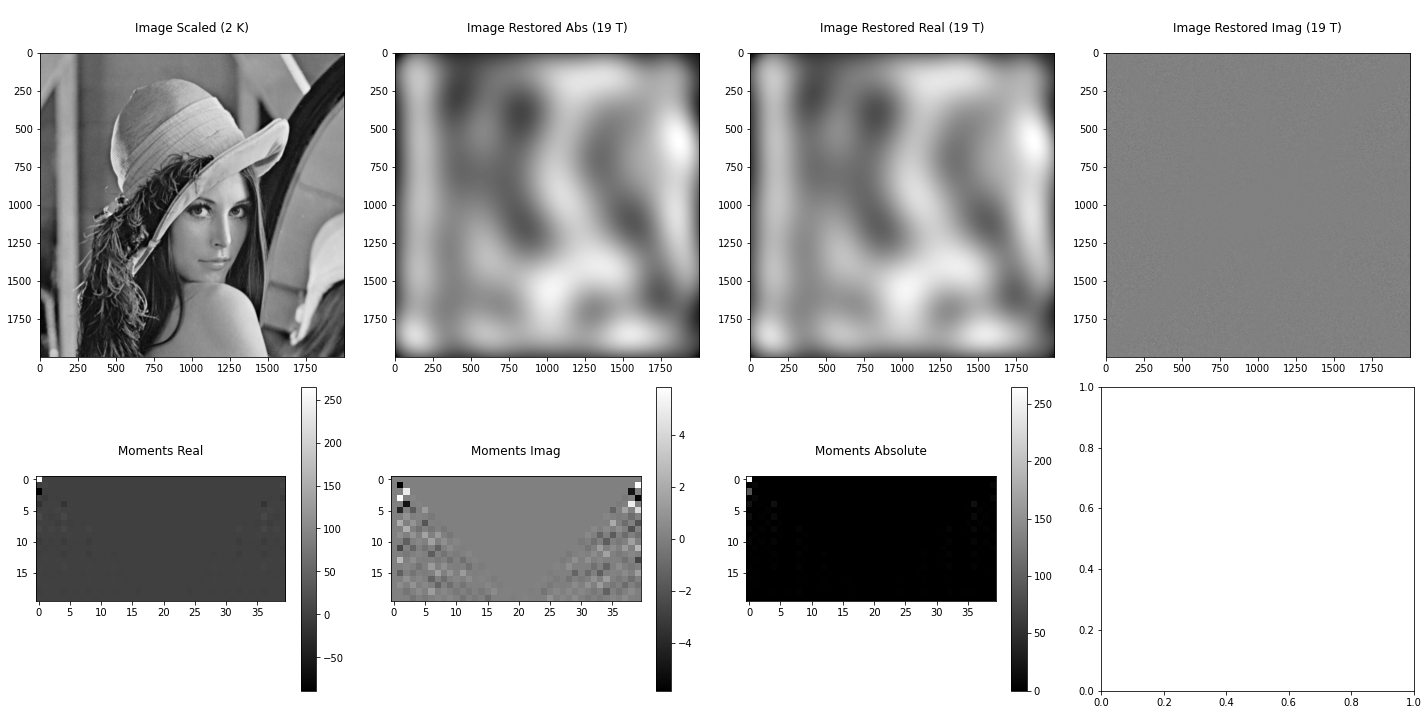


Done.
Wall time: 2min 32s


In [20]:
%%time

from IPython.display import clear_output
clear_output()

# 저니크 모멘트 계산 

from AZernike import *

def pq_list( T ) :
    pqs = []

    for p in range( 0, T ) : 
        for q in range( -p, p + 1, 2 ) :
            pqs.append( [p, q] )        
        pass
    pass

    return pqs
pass # pq_list

def calc_moments( T, img, rho, theta, dx, dy , use_gpu=1, hash={}, use_hash=1, debug=0) : 
    s = T
    moments = np.zeros( (s, s*2), np.complex_ )

    img_flat = img.flatten()

    print( "img shape= ", img_flat.shape )

    pqs = pq_list( s )

    for p, q in pqs :
        v_pq = Vpq( p, q, rho, theta, use_gpu, hash=hash, use_hash=use_hash, debug=0 )
        moment = np.dot( v_pq, img_flat )*dx*dy
        
        moments[ p, q ] = moment
        
        #print( f"moment({p:2d}, {q:3d}) = ", moment )
    pass

    if 0 :
        print( "Moments = ", moments )
    pass

    return moments
pass # calc_moments

def restore_image(moments, rho, theta, use_gpu=1, hash={}, use_hash=1, debug=0) : 
    np = cupy if use_gpu else numpy
    
    s = moments.shape[0]
    img = np.zeros_like( rho, np.complex_ )
    
    pqs = pq_list( s )
    
    for p, q in pqs :
        img += (p+1)/pi*moments[p, q]*Vpq( p, q, rho, theta, use_gpu, hash=hash, use_hash=use_hash, debug=0 ) 
    pass 

    s = int( math.sqrt( len( img ) ) )
    
    img = img.reshape( s, s )
    
    return img 
pass

print_curr_time()

debug = 0

img = cv.imread( 'image/lenna.png', 0 )

print( "img shape= ", img.shape )

img_org = img 

K = 2
s = 1_000*K

use_gpu = 1
use_hash = 1

np = cupy if use_gpu else cupy

img = cv.resize( img_org, (s, s), interpolation=cv.INTER_AREA )
img = np.array( img )

print( "img shape= ", img.shape )

circle_type = "outer"
rho, theta, x, y, dx, dy, k = rho_theta( img, circle_type, use_gpu=use_gpu, debug = debug) 

print( f"rho shape = {rho.shape}" )

T = 20
print( f"K = {K}, T = {T}" )
hash = {}

moments = calc_moments(T, img, rho, theta, dx, dy, use_gpu=use_gpu, hash=hash, use_hash=use_hash, debug=debug)
img_restored = restore_image(moments, rho, theta, use_gpu=use_gpu, hash=hash, use_hash=use_hash, debug=debug)

del hash 

print( "\nPlotting .... ")

imgs = []

imgs.append( { "title" : f"Image Scaled ({K} K)", "img" : img } )
imgs.append( { "title" : f"Image Restored Abs ({T-1} T)", "img" : np.absolute( img_restored ) } )
imgs.append( { "title" : f"Image Restored Real ({T-1} T)", "img" : img_restored.real } )
imgs.append( { "title" : f"Image Restored Imag ({T-1} T)", "img" : img_restored.imag } )
imgs.append( { "title" : "Moments Real", "img" : moments.real, "colorbar" : 1 } )
imgs.append( { "title" : "Moments Imag", "img" : moments.imag, "colorbar" : 1 } ) 
imgs.append( { "title" : "Moments Absolute", "img" : np.absolute( moments.real ), "colorbar" : 1 } )

# 서브 챠트 생성 
col_cnt = 4
row_cnt = len( imgs ) // col_cnt
if col_cnt*row_cnt < len( imgs ) :
    row_cnt += 1
pass

fig, charts = plt.subplots( row_cnt, col_cnt, figsize=(5*col_cnt, 5*row_cnt) )
charts = charts.ravel() if row_cnt*col_cnt > 1 else [charts]
chart_idx = 0 

for img in imgs : 
    t_img = img[ "img" ]
    title = img[ "title" ]
    colorbar = False 
    if "colorbar" in img :
        colorbar = img[ "colorbar" ]

    chart = charts[ chart_idx ] ; chart_idx += 1
    chart.set_title( f"\n{title}\n" )
    pos = chart.imshow( cupy.asnumpy( t_img ) if use_gpu else t_img, cmap='gray' )
    colorbar and fig.colorbar(pos, ax=chart)
pass

if 0 : 
    chart.set_xlim( 0 , t_img.shape[1] - 1 )
    chart.set_ylim( 0 , t_img.shape[0] - 1)
    chart.set_yticks( np.arange( 0, t_img.shape[1]))
    chart.set_yticks( np.arange( 0, t_img.shape[0])[::-1])
    chart.axhline(y=0, color='k')
    chart.axvline(x=0, color='k')

    chart.add_artist( plt.Circle((0, 0), 1, fill=0) )
    chart.scatter( x, y, marker="." )

plt.tight_layout(); plt.show()  

print( "\nDone." )